# Visualize Demand of Top Selling Products 

### Import Necessary Packages

In [1]:
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc

### Load the data 

In [2]:
def load_data(): 
    """ Loads and returns train, test, products, and predictions data. 
    """
    # Set work directory
    os.chdir('D:/OneDrive/Documents/Kaggle/Grupo Bimbo Inventory Demand/data')  
    
    # Load data
    train_types = {'Semana': np.uint8, 'Cliente_ID': np.uint32, 'Producto_ID': np.uint16, 'Demanda_uni_equil': np.float16}  
    test_types = {'Semana': np.uint8, 'Cliente_ID': np.uint32, 'Producto_ID': np.uint16}     
    product_types = {'Producto_ID': np.uint16, 'short_product_name': np.object}
    
    train = pd.read_csv("train.csv", sep = ",", usecols = train_types.keys(), dtype = train_types) 
    test = pd.read_csv("test.csv", sep = ",", usecols = test_types.keys(), dtype = test_types) 
    products = pd.read_csv("producto_tabla_modified.csv", sep = ",", usecols = product_types.keys(), dtype = product_types) 
    predictions = pd.read_csv("submission_xgb_Semana_9_cv_score_0.4656_LB_score_.csv", sep = ",")

    # Return data
    return train, test, products, predictions

In [3]:
print "1. Loading data..."
train, test, products, predictions = load_data() 
print "Complete!"

1. Loading data...
Complete!


### Merge with product data

In [4]:
def merge_products(train, test, products):
    """ Merge train and test data sets with products dataframe.
        Returns modified train and test data.
    """
    # Merge product information
    train = train.merge(products, how = 'left', on = ['Producto_ID'])
    test = test.merge(products, how = 'left', on = ['Producto_ID'])

    return train, test  

In [5]:
print "2. Merge data with products dataframe..."
train, test = merge_products(train, test, products)
print "Complete!"

2. Merge data with products dataframe...
Complete!


### Concatenate predictions with test data

In [6]:
def concatenate_data(train, test, predictions):
    """ Adds predictions as column in test data labelled 'Demanda_uni_equil'. 
        Reorders columns in train and test data.
        Concatenates train and test sets together row-wise, preserving columns of dataframes. 
        Returns concatenated data set.
    """
    test = pd.concat([test, predictions], axis = 1)
    test = test.drop('id', axis = 1)    
    
    columns = ['Semana', 'Cliente_ID', 'Producto_ID', 'short_product_name', 'Demanda_uni_equil']
    train = train[columns]
    test = test[columns]
    
    train = pd.concat([train, test], axis = 0)
    return train

In [7]:
print "3. Concatenate data..."
data = concatenate_data(train, test, predictions)

# Remove other dataframes from memory
del train, test, predictions
gc.collect()
    
print "Complete!"

3. Concatenate data...
Complete!


The data should now have the combined train and test data with predictions with Semana (week) in 10 and 11. Let's take a look at the header of the data...

In [8]:
data.head()

,Semana,Cliente_ID,Producto_ID,short_product_name,Demanda_uni_equil
0,3,15766,1212,rol canel,3.0
1,3,15766,1216,rol glass,4.0
2,3,15766,1238,panquecit got choc,4.0
3,3,15766,1240,mantec vainill,4.0
4,3,15766,1242,donit espolvor,3.0


From our exploratory analysis in another Jupyter notebook, we know that nit, gansit, reban, and pan blanc are the top 4 best selling products in our data. Let's visualize the mean adjusted sales of each product by week...

In [9]:
print "4. Show mean demand for top 2 products by week..."
top_products = ['nit', 'gansit', 'reban', 'pan blanc']
columns = ['Semana', 'short_product_name', 'Demanda_uni_equil']
data = data.ix[data['short_product_name'].isin(top_products), columns]
columns.remove('Demanda_uni_equil')
df = pd.DataFrame({'Adjusted Sales' : data.groupby(columns)['Demanda_uni_equil'].mean()}).reset_index()      
df = df.sort_values(by = ['short_product_name', 'Semana'], ascending = True)
df = df.reset_index(drop = True)
print 'Shape: ' + str(df.shape)
df.head(n=9)

4. Show mean demand for top 2 products by week...
Shape: (36, 3)


,Semana,short_product_name,Adjusted Sales
0,3,gansit,13.282085
1,4,gansit,13.056975
2,5,gansit,13.490020
3,6,gansit,12.990436
4,7,gansit,12.929077
5,8,gansit,12.588106
6,9,gansit,12.781615
7,10,gansit,10.821687
8,11,gansit,10.781094


### Visualize adjusted sales

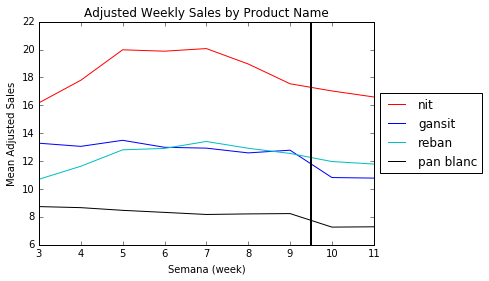

In [11]:
plt.plot(df.ix[df['short_product_name'] == 'nit', 'Semana'], df.ix[df['short_product_name'] == 'nit', 'Adjusted Sales']
         , label = 'nit', color = 'r')
plt.plot(df.ix[df['short_product_name'] == 'gansit', 'Semana'], df.ix[df['short_product_name'] == 'gansit', 'Adjusted Sales']
         , label = 'gansit', color = 'b')
plt.plot(df.ix[df['short_product_name'] == 'reban', 'Semana'], df.ix[df['short_product_name'] == 'reban', 'Adjusted Sales']
         , label = 'reban', color = 'c')
plt.plot(df.ix[df['short_product_name'] == 'pan blanc', 'Semana'], df.ix[df['short_product_name'] == 'pan blanc', 'Adjusted Sales']
         , label = 'pan blanc', color = 'black')

plt.axvline(x=9.5, linewidth=2, color='black')
plt.xlabel('Semana (week)')
plt.ylabel('Mean Adjusted Sales')
plt.title('Adjusted Weekly Sales by Product Name')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Mean Adjusted Weekly Sales for the train data are shown on the left-hand side of the thick, vertical black line, and sales for the test data are shown on its right-hand side. We can see that the predicted Adjusted Demand in the test data is lower than in the prior weeks for each of the different products. However, each of the products have differing sales trends.